### install

In [4]:
# Restart runtime
!pip install sdv
!pip install sdmetrics
!pip install Autogluon

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 30.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.3/160.3 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 16.8 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.4
    Uninstalling urllib3-2.0.4:
      Successfully uninstalled urllib3-2.0.4
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### import

In [1]:
# import
import pandas as pd
import os
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from sdv.metadata import SingleTableMetadata
from sdv.single_table import CTGANSynthesizer
import plotly.graph_objects as go
from sdmetrics.single_column import KSComplement
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import run_diagnostic
from sdv.evaluation.single_table import get_column_plot
from sdv.sampling import Condition
from autogluon.tabular import TabularPredictor

### Data load & processing

In [3]:
# 구글 드라이브 마운트
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# 소프트링크
!ln -s /content/drive/MyDrive/Colab\ Notebooks/DACON/dacon-lettuce-generative /mydrive
!ls /mydrive

AutoGluon		  EDA.ipynb		model_param	terminal.ipynb
code_example		  evaluation.ipynb	open.zip	vae.ipynb
CTGAN.ipynb		  for_git_commit.ipynb	results
dacon-lettuce-generative  lstm.ipynb		synthetic_data


In [5]:
# 압축풀기
!mkdir /content/dataset
!cd /mydrive; unzip open.zip -d /content/dataset

mkdir: cannot create directory ‘/content/dataset’: File exists
Archive:  open.zip
replace /content/dataset/sample_submission.zip? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [6]:
!ls -lia /content/dataset

total 28
7078107 drwxr-xr-x 6 root root 4096 Sep 17 14:47 .
2752518 drwxr-xr-x 1 root root 4096 Sep 17 14:47 ..
7078110 -rw-r--r-- 1 root root 1142 Nov 21  2022 sample_submission.zip
7078111 drwxr-xr-x 2 root root 4096 Nov 20  2022 test_input
7078117 drwxr-xr-x 2 root root 4096 Nov 21  2022 test_target
7078123 drwxr-xr-x 2 root root 4096 Nov 20  2022 train_input
7078152 drwxr-xr-x 2 root root 4096 Nov 20  2022 train_target


In [7]:
# data load & preprocessing
def make_traindata_ctgan(input_dir_list):
  train_all = pd.DataFrame()
  for i in range(len(input_dir_list)):
    train_df = pd.read_csv(input_dir_list[i])
    train_df['Case'] = i + 1
    train_all = pd.concat([train_all, train_df])
  train_all['obs_time'] = pd.to_datetime(train_all['obs_time'])
  train_all['obs_time'] = train_all['obs_time'].dt.hour

  # 이상값 처리
  # 내부온도,습도=0 -> 평균으로 대체
  # print(round(train_all[(train_all['DAT'] == 0) & (train_all['obs_time'] == 15) & (train_all['Case'] != 4)]['내부온도관측치'].mean(), 6))
  # print(round(train_all[(train_all['DAT'] == 0) & (train_all['obs_time'] == 15) & (train_all['Case'] != 4)]['내부습도관측치'].mean(), 6))
  train_all.loc[train_all['내부온도관측치'] == 0, '내부온도관측치'] = 28.479124
  train_all.loc[train_all['내부습도관측치'] == 0, '내부습도관측치'] = 53.469956

  # 시간당분무량<0 -> 0으로 대체
  train_all.loc[train_all['시간당분무량'] < 0, '시간당분무량'] = 0

  # 시간당백색,적색,청색광량<0 -> 최빈값으로 대체
  # print(train_all.loc[train_all['시간당백색광량'] < 0, ['DAT', 'obs_time', 'Case']])
  # print(train_all.loc[train_all['시간당적색광량'] < 0, ['DAT', 'obs_time', 'Case']])
  # print(train_all.loc[train_all['시간당청색광량'] < 0, ['DAT', 'obs_time', 'Case']])
  # print(train_all[(train_all['DAT'] == 0) & (train_all['obs_time'] == 15) & (train_all['Case'] != 6)]['시간당백색광량'].mode())
  # print(train_all[(train_all['DAT'] == 0) & (train_all['obs_time'] == 15) & (train_all['Case'] != 6)]['시간당적색광량'].mode())
  # print(train_all[(train_all['DAT'] == 0) & (train_all['obs_time'] == 15) & (train_all['Case'] != 6)]['시간당청색광량'].mode())
  train_all.loc[train_all['시간당백색광량'] < 0, '시간당백색광량'] = 18255.19
  train_all.loc[train_all['시간당적색광량'] < 0, '시간당적색광량'] = 0
  train_all.loc[train_all['시간당청색광량'] < 0, '시간당청색광량'] = 0

  # 누적, 시간당총광량 column 삭제
  col_names = train_all.columns
  drop_feature_list = ['DAT', 'obs_time', 'Case', '시간당총광량']
  for col in col_names:
    if '누적' in col or col in drop_feature_list:
      train_all = train_all.drop(col, axis=1)

  # print(train_all)
  # 시간별 데이터 -> 일별 데이터
  train_list = []
  train_len = int(train_all.shape[0] / 24)

  for i in range(train_len):
    day_data = train_all[24*i:24*(i+1)]
    time_series = day_data.values.flatten().tolist() + [i%28]
    train_list.append(time_series)

  all_col = []
  for hour in range(24):
    for col in train_all.columns:
      all_col.append(f'{hour}시_{col}')
  all_col.append('day')

  train = pd.DataFrame(train_list, columns=all_col)

  return train

In [8]:
def make_data(df, day):

  # 새로운 feature 생성
  df['온습도'] = df['내부온도관측치'] * df['내부습도관측치']
  df['온도co2'] = df['내부온도관측치'] * df['co2관측치']
  df['습도co2'] = df['내부습도관측치'] * df['내부습도관측치']
  df['온습도co2'] = df['내부온도관측치'] * df['내부습도관측치'] * df['co2관측치']
  df['광량여부'] = (df['시간당백색광량'] + df['시간당적색광량'] + df['시간당청색광량']).map(lambda x: 0 if x == 0 else 1)

  # 누적, 시간당총광량 column 삭제
  col_names = df.columns
  drop_feature_list = ['DAT', 'obs_time', 'Case', '시간당총광량']
  for col in col_names:
    if '누적' in col or col in drop_feature_list:
      df = df.drop(col, axis=1)

  # 시간별 데이터 -> 일별 데이터
  sample_list = []
  len_df = int(df.shape[0]/24)

  for i in range(len_df):
    day_data = df.iloc[24*i:24*(i+1)]
    time_series = day_data.values.flatten().tolist() + [day]
    sample_list.append(time_series)

  all_col = []
  for hour in range(24):
    for col in df.columns:
      all_col.append(f'{hour}시_{col}')
  all_col.append('day')

  sample_data = pd.DataFrame(sample_list, columns=all_col)

  return sample_data

In [9]:
train_input_dir = sorted(glob('/content/dataset/train_input/*.csv'))
train = make_traindata_ctgan(train_input_dir)

### CTGAN

In [10]:
metadata = SingleTableMetadata()

In [11]:
metadata.detect_from_dataframe(train)

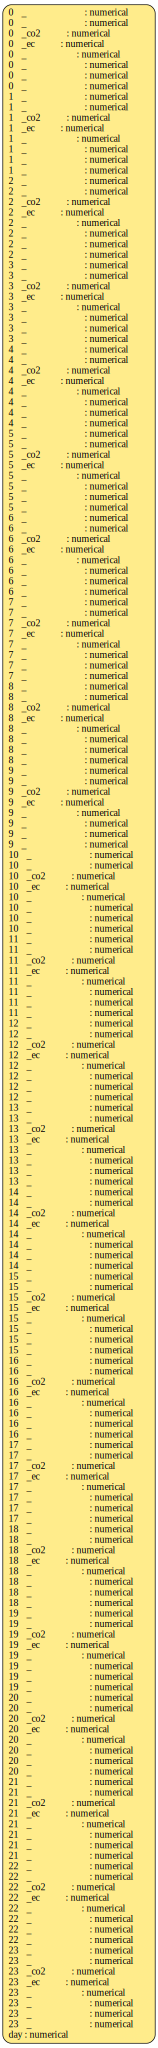

In [12]:
metadata.visualize()

In [13]:
synthesizer = CTGANSynthesizer(metadata, epochs=300, verbose=True)

In [14]:
%%capture output
synthesizer.fit(train)

In [15]:
!mkdir /mydrive/model_param
synthesizer.save(filepath='/mydrive/model_param/my_synthesizer.pkl')

mkdir: cannot create directory ‘/mydrive/model_param’: File exists


In [ ]:
# Format the output into a table named loss_values
epochs_output = str(output).split('\n')
raw_values = [line.split(',') for line in epochs_output]

loss_values = pd.DataFrame(raw_values)[:-1]
loss_values.columns = ['Epoch', 'Generator Loss', 'Discriminator Loss']
loss_values['Epoch'] = loss_values['Epoch'].str.extract('(\d+)').astype(int)
loss_values['Generator Loss'] = loss_values['Generator Loss'].str.extract('([-+]?\d*\.\d+|\d+)').astype(float)
loss_values['Discriminator Loss'] = loss_values['Discriminator Loss'].str.extract('([-+]?\d*\.\d+|\d+)').astype(float)

### Epoch vs. Loss

In [ ]:
# Graph the table
fig = go.Figure(data=[go.Scatter(x=loss_values['Epoch'], y=loss_values['Generator Loss'], name='Generator Loss'),
                      go.Scatter(x=loss_values['Epoch'], y=loss_values['Discriminator Loss'], name='Discriminator Loss')])

fig.update_layout(title='CTGAN Loss Values', xaxis_title='Epoch', yaxis_title='Loss')
fig.show()

### Sampling

In [ ]:
synthetic_data = synthesizer.sample(num_rows=train.shape[0])

### Evaluation

In [ ]:
quality_report = evaluate_quality(real_data=train,
                                  synthetic_data=synthetic_data,
                                  metadata=metadata)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 18528/18528 [03:15<00:00, 94.94it/s]

Overall Quality Score: 80.95%

Properties:
- Column Shapes: 72.62%
- Column Pair Trends: 89.28%


In [ ]:
quality_report.get_score()

0.8095017936962227

In [ ]:
quality_report.get_properties()

,Property,Score
0,Column Shapes,0.726201
1,Column Pair Trends,0.892802


In [ ]:
quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,0시_내부온도관측치,KSComplement,0.831633
1,0시_내부습도관측치,KSComplement,0.653061
2,0시_co2관측치,KSComplement,0.900510
3,0시_ec관측치,KSComplement,0.692602
4,0시_시간당분무량,KSComplement,0.806122
...,...,...,...
188,23시_시간당분무량,KSComplement,0.562500
189,23시_시간당백색광량,KSComplement,0.720663
190,23시_시간당적색광량,KSComplement,0.309949
191,23시_시간당청색광량,KSComplement,0.679847


In [ ]:
quality_report.get_visualization(property_name='Column Shapes')

In [ ]:
diagnostic_report = run_diagnostic(real_data=train,
                                     synthetic_data=synthetic_data,
                                     metadata=metadata)

Generating report ...
(3/3) Evaluating Synthesis: : 100%|██████████| 1/1 [09:09<00:00, 549.22s/it]

Diagnostic Results:

SUCCESS:
✓ The synthetic data covers over 90% of the numerical ranges present in the real data
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data
✓ Over 90% of the synthetic rows are not copies of the real data


In [ ]:
diagnostic_report.get_results()

{'SUCCESS': ['The synthetic data covers over 90% of the numerical ranges present in the real data',
  'The synthetic data follows over 90% of the min/max boundaries set by the real data',
  'Over 90% of the synthetic rows are not copies of the real data'],
 'WARNING': [],
 'DANGER': []}

In [ ]:
diagnostic_report.get_properties()

,Property,Score
0,Coverage,0.950501
1,Boundary,1.000000
2,Synthesis,1.000000


In [ ]:
diagnostic_report.get_details(property_name='Coverage')

,Column,Metric,Score
0,0시_내부온도관측치,RangeCoverage,0.781355
1,0시_내부습도관측치,RangeCoverage,1.000000
2,0시_co2관측치,RangeCoverage,0.760702
3,0시_ec관측치,RangeCoverage,0.913052
4,0시_시간당분무량,RangeCoverage,1.000000
...,...,...,...
188,23시_시간당분무량,RangeCoverage,1.000000
189,23시_시간당백색광량,RangeCoverage,1.000000
190,23시_시간당적색광량,RangeCoverage,1.000000
191,23시_시간당청색광량,RangeCoverage,1.000000


In [ ]:
fig = get_column_plot(real_data=train,
                      synthetic_data=synthetic_data,
                      column_name='23시_시간당청색광량',
                      metadata=metadata)

fig.show()

In [ ]:
# synthetic data -> raw data
def make_raw (df, day):
  df_numpy = df.values
  return_arr = []

  for i in range(len(df_numpy)) :
    now = df_numpy[i]
    for j in range(24):
      value = np.insert(now[j*8:j*8+8],0, int(day)) # dat
      value = np.insert(value , 1 ,int(j)) # obs_time
      value = np.insert(value , 0 ,int(i)) # case
      return_arr.append(value.tolist())

  return_df = pd.DataFrame(np.array(return_arr),columns = ['Case','DAT', 'obs_time', '내부온도관측치', '내부습도관측치','co2관측치',
                                      'ec관측치', '시간당분무량', '시간당백색광량',  '시간당적색광량',  '시간당청색광량' ])

  return_df['시간당총광량'] = return_df['시간당백색광량'] + return_df['시간당적색광량'] + return_df['시간당청색광량']

  # 중앙값 차이 값으로 값 변환
  return_df['내부온도관측치'] =  return_df['내부온도관측치']  - 2
  return_df['시간당분무량'] = return_df['시간당분무량'] + 1251.865000
  return_df['ec관측치'] = return_df['ec관측치'] +1.7

  cumsum_list = ['일간누적분무량', '일간누적백색광량', '일간누적적색광량', '일간누적청색광량', '일간누적총광량']
  per_time_list = ['시간당분무량', '시간당백색광량', '시간당적색광량', '시간당청색광량', '시간당총광량']

  for i in range(0, 5):
    col1 = cumsum_list[i]
    col2 = per_time_list[i]
    return_df[col1] = 0
    return_df[col1] = return_df.groupby((return_df.obs_time == 0).cumsum()).agg(col2).cumsum()

  return_df = return_df[['Case', 'DAT', 'obs_time', '내부온도관측치', '내부습도관측치', 'co2관측치', 'ec관측치', '시간당분무량',
            '일간누적분무량', '시간당백색광량', '일간누적백색광량', '시간당적색광량', '일간누적적색광량', '시간당청색광량',
            '일간누적청색광량', '시간당총광량', '일간누적총광량']]

  return return_df

### Divide growing period into 0-6/7-13/14-20/21-27

In [ ]:
!mkdir /mydrive/synthetic_data
!mkdir /mydrive/model_param

input_path_dir = sorted(glob('/content/dataset/train_input/*.csv'))
output_path = '/mydrive/synthetic_data'

mkdir: cannot create directory ‘/mydrive/synthetic_data’: File exists


In [ ]:
def generate_synthetic_data(input_path_dir, output_path):
  train = make_traindata_ctgan(input_path_dir)
  n_cases = int(train.shape[0]/28)

  input_train = pd.DataFrame()
  for i in range(n_cases):
    day7 = train.iloc[28*i:28*i+7]
    input_train = pd.concat([input_train, day7], axis=0).reset_index(drop=True)
  synthesizer7 = CTGANSynthesizer(metadata, epochs=300, verbose=True)
  synthesizer7.fit(input_train)
  synthesizer7.save(filepath='/mydrive/model_param/gen_model_7.pkl')
  # Conditional sampling by day0-6(#sampling=50)
  for i in range(7):
    dayi = Condition(num_rows=50, column_values={'day': i})
    synthetic_data_dayi = synthesizer7.sample_from_conditions(conditions=[dayi])
    gen_data_dayi = make_raw(synthetic_data_dayi, i)
    gen_data_dayi.to_csv(os.path.join(output_path, f'day{i}.csv'))

  input_train = pd.DataFrame()
  for i in range(n_cases):
    day14 = train.iloc[28*i+7:28*i+14]
    input_train = pd.concat([input_train, day14], axis=0).reset_index(drop=True)
  synthesizer14 = CTGANSynthesizer(metadata, epochs=300, verbose=True)
  synthesizer14.fit(input_train)
  synthesizer14.save(filepath='/mydrive/model_param/gen_model_14.pkl')
  # Conditional sampling by day7-13(#sampling=50)
  for i in range(7, 14):
    dayi = Condition(num_rows=50, column_values={'day': i})
    synthetic_data_dayi = synthesizer14.sample_from_conditions(conditions=[dayi])
    gen_data_dayi = make_raw(synthetic_data_dayi, i)
    gen_data_dayi.to_csv(os.path.join(output_path, f'day{i}.csv'))

  input_train = pd.DataFrame()
  for i in range(n_cases):
    day21 = train.iloc[28*i+14:28*i+21]
    input_train = pd.concat([input_train, day21], axis=0).reset_index(drop=True)
  synthesizer21 = CTGANSynthesizer(metadata, epochs=300, verbose=True)
  synthesizer21.fit(input_train)
  synthesizer21.save(filepath='/mydrive/model_param/gen_model_21.pkl')
  # Conditional sampling by day14-20(#sampling=50)
  for i in range(14, 21):
    dayi = Condition(num_rows=50, column_values={'day': i})
    synthetic_data_dayi = synthesizer21.sample_from_conditions(conditions=[dayi])
    gen_data_dayi = make_raw(synthetic_data_dayi, i)
    gen_data_dayi.to_csv(os.path.join(output_path, f'day{i}.csv'))

  input_train = pd.DataFrame()
  for i in range(n_cases):
    day28 = train.iloc[28*i+21:28*i+28]
    input_train = pd.concat([input_train, day28], axis=0).reset_index(drop=True)
  synthesizer28 = CTGANSynthesizer(metadata, epochs=300, verbose=True)
  synthesizer28.fit(input_train)
  synthesizer28.save(filepath='/mydrive/model_param/gen_model_28.pkl')
  # Conditional sampling by day21-27(#sampling=50)
  for i in range(21, 28):
    dayi = Condition(num_rows=50, column_values={'day': i})
    synthetic_data_dayi = synthesizer28.sample_from_conditions(conditions=[dayi])
    gen_data_dayi = make_raw(synthetic_data_dayi, i)
    gen_data_dayi.to_csv(os.path.join(output_path, f'day{i}.csv'))

In [ ]:
generate_synthetic_data(input_path_dir, output_path)

/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column '0시_co2관측치'. Data will not be rounded.

/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column '0시_ec관측치'. Data will not be rounded.

/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column '0시_시간당분무량'. Data will not be rounded.

/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column '0시_시간당청색광량'. Data will not be rounded.

/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column '1시_co2관측치'. Data will not be rounded.

/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column '1시_ec관측치'. Data will not be rou

Epoch 1, Loss G:  0.0803,Loss D: -0.0039
Epoch 2, Loss G:  0.3396,Loss D: -0.3722
Epoch 3, Loss G:  0.5712,Loss D: -0.8835
Epoch 4, Loss G:  0.8765,Loss D: -1.5521
Epoch 5, Loss G:  1.1871,Loss D: -2.3089
Epoch 6, Loss G:  1.4645,Loss D: -3.0136
Epoch 7, Loss G:  1.7417,Loss D: -3.7121
Epoch 8, Loss G:  1.9196,Loss D: -4.4451
Epoch 9, Loss G:  2.0694,Loss D: -5.0710
Epoch 10, Loss G:  2.1590,Loss D: -5.7278
Epoch 11, Loss G:  2.2870,Loss D: -6.2401
Epoch 12, Loss G:  2.4861,Loss D: -6.7273
Epoch 13, Loss G:  2.4024,Loss D: -7.3923
Epoch 14, Loss G:  2.3687,Loss D: -7.4805
Epoch 15, Loss G:  2.5379,Loss D: -7.8535
Epoch 16, Loss G:  2.1129,Loss D: -7.9581
Epoch 17, Loss G:  1.7912,Loss D: -7.3841
Epoch 18, Loss G:  0.7592,Loss D: -6.8850
Epoch 19, Loss G:  0.6411,Loss D: -6.2889
Epoch 20, Loss G: -0.1545,Loss D: -5.8647
Epoch 21, Loss G: -0.7405,Loss D: -4.9883
Epoch 22, Loss G: -0.5132,Loss D: -4.4919
Epoch 23, Loss G: -0.9061,Loss D: -3.5228
Epoch 24, Loss G: -1.2668,Loss D: -4.3533
E

Sampling conditions: 100%|██████████| 50/50 [00:05<00:00,  8.80it/s]
/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column '0시_co2관측치'. Data will not be rounded.

/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column '0시_ec관측치'. Data will not be rounded.

/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column '0시_시간당분무량'. Data will not be rounded.

/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column '0시_시간당청색광량'. Data will not be rounded.

/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column '1시_co2관측치'. Data will not be rounded.

/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No

Epoch 1, Loss G:  0.1535,Loss D:  0.0060
Epoch 2, Loss G:  0.3343,Loss D: -0.3950
Epoch 3, Loss G:  0.5867,Loss D: -0.9250
Epoch 4, Loss G:  0.9007,Loss D: -1.5422
Epoch 5, Loss G:  1.1778,Loss D: -2.2687
Epoch 6, Loss G:  1.4109,Loss D: -3.2349
Epoch 7, Loss G:  1.5904,Loss D: -4.1390
Epoch 8, Loss G:  1.5661,Loss D: -4.8689
Epoch 9, Loss G:  1.7979,Loss D: -5.7406
Epoch 10, Loss G:  1.8575,Loss D: -6.1801
Epoch 11, Loss G:  1.7966,Loss D: -7.0060
Epoch 12, Loss G:  1.6962,Loss D: -7.8014
Epoch 13, Loss G:  1.9776,Loss D: -8.0110
Epoch 14, Loss G:  1.8571,Loss D: -8.9803
Epoch 15, Loss G:  1.3462,Loss D: -9.0626
Epoch 16, Loss G:  1.1458,Loss D: -8.3315
Epoch 17, Loss G:  0.3269,Loss D: -8.8222
Epoch 18, Loss G: -0.1710,Loss D: -8.4871
Epoch 19, Loss G: -0.5705,Loss D: -7.3958
Epoch 20, Loss G: -1.4435,Loss D: -7.5061
Epoch 21, Loss G: -1.7972,Loss D: -6.7710
Epoch 22, Loss G: -1.8822,Loss D: -5.6529
Epoch 23, Loss G: -2.0079,Loss D: -5.3513
Epoch 24, Loss G: -2.2471,Loss D: -5.1660
E

Sampling conditions: 100%|██████████| 50/50 [00:05<00:00,  9.72it/s]
/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column '0시_co2관측치'. Data will not be rounded.

/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column '0시_ec관측치'. Data will not be rounded.

/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column '0시_시간당분무량'. Data will not be rounded.

/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column '0시_시간당청색광량'. Data will not be rounded.

/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column '1시_co2관측치'. Data will not be rounded.

/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No

Epoch 1, Loss G:  0.1767,Loss D:  0.0009
Epoch 2, Loss G:  0.3133,Loss D: -0.3771
Epoch 3, Loss G:  0.4858,Loss D: -0.8488
Epoch 4, Loss G:  0.7390,Loss D: -1.5559
Epoch 5, Loss G:  1.0153,Loss D: -2.1795
Epoch 6, Loss G:  1.1168,Loss D: -2.9365
Epoch 7, Loss G:  1.3692,Loss D: -3.6450
Epoch 8, Loss G:  1.5633,Loss D: -4.0786
Epoch 9, Loss G:  1.4712,Loss D: -4.9095
Epoch 10, Loss G:  1.7099,Loss D: -5.3917
Epoch 11, Loss G:  1.9167,Loss D: -6.1218
Epoch 12, Loss G:  1.9115,Loss D: -6.3478
Epoch 13, Loss G:  2.1117,Loss D: -7.0226
Epoch 14, Loss G:  1.9425,Loss D: -7.1401
Epoch 15, Loss G:  1.9327,Loss D: -7.2416
Epoch 16, Loss G:  1.6299,Loss D: -6.8249
Epoch 17, Loss G:  0.8231,Loss D: -6.6834
Epoch 18, Loss G:  1.0087,Loss D: -6.0761
Epoch 19, Loss G:  0.1755,Loss D: -5.1525
Epoch 20, Loss G: -0.3514,Loss D: -4.8668
Epoch 21, Loss G: -0.5978,Loss D: -4.3744
Epoch 22, Loss G: -1.0851,Loss D: -4.0186
Epoch 23, Loss G: -1.0262,Loss D: -3.8598
Epoch 24, Loss G: -1.4238,Loss D: -3.4953
E

Sampling conditions: 100%|██████████| 50/50 [00:08<00:00,  5.82it/s]
/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column '0시_co2관측치'. Data will not be rounded.

/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column '0시_ec관측치'. Data will not be rounded.

/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column '0시_시간당분무량'. Data will not be rounded.

/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column '0시_시간당청색광량'. Data will not be rounded.

/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No rounding scheme detected for column '1시_co2관측치'. Data will not be rounded.

/usr/local/lib/python3.10/dist-packages/rdt/transformers/numerical.py:112: UserWarning:

No

Epoch 1, Loss G:  0.1538,Loss D:  0.0033
Epoch 2, Loss G:  0.3299,Loss D: -0.3591
Epoch 3, Loss G:  0.5592,Loss D: -0.7420
Epoch 4, Loss G:  0.8776,Loss D: -1.4848
Epoch 5, Loss G:  1.0490,Loss D: -2.0515
Epoch 6, Loss G:  1.3954,Loss D: -2.7141
Epoch 7, Loss G:  1.5789,Loss D: -3.3528
Epoch 8, Loss G:  1.6921,Loss D: -4.2171
Epoch 9, Loss G:  1.9104,Loss D: -4.7068
Epoch 10, Loss G:  1.8901,Loss D: -5.3532
Epoch 11, Loss G:  2.2176,Loss D: -5.5324
Epoch 12, Loss G:  2.0788,Loss D: -5.8392
Epoch 13, Loss G:  2.3837,Loss D: -6.4580
Epoch 14, Loss G:  2.2488,Loss D: -6.6849
Epoch 15, Loss G:  2.6532,Loss D: -6.8662
Epoch 16, Loss G:  2.5052,Loss D: -7.4138
Epoch 17, Loss G:  2.2028,Loss D: -6.7999
Epoch 18, Loss G:  1.5828,Loss D: -7.0554
Epoch 19, Loss G:  1.8230,Loss D: -6.8140
Epoch 20, Loss G:  1.3057,Loss D: -6.6688
Epoch 21, Loss G:  0.7265,Loss D: -5.5184
Epoch 22, Loss G:  0.4270,Loss D: -4.6496
Epoch 23, Loss G:  0.1253,Loss D: -4.8833
Epoch 24, Loss G: -0.4599,Loss D: -3.9023
E

Sampling conditions: 100%|██████████| 50/50 [00:03<00:00, 13.33it/s]


In [ ]:
predictor = TabularPredictor.load('/mydrive/results/exp_1')

max_df = pd.DataFrame()
for i in range(28):
  gen_data = pd.read_csv(f'/mydrive/synthetic_data/day{i}.csv', index_col=0)
  gen_data_new = make_data(gen_data, i)
  y_pred = predictor.predict(gen_data_new)
  max_idx = np.argmax(y_pred)
  max_df = pd.concat([max_df, gen_data_new.iloc[[max_idx]]], axis=0).reset_index(drop=True)
